In [2]:
import os
import sys
from pathlib import Path

import cv2
import cv2 as cv
import h5py
import matplotlib.pyplot as plt
import napari
import numpy as np
import pandas as pd
import skimage
from joblib import Parallel, delayed
from skimage import exposure, io
from skimage.util import img_as_ubyte
from tqdm.notebook import tqdm, trange

In [3]:
p_dir = (Path().cwd().parents[0]).absolute()
data_dir = p_dir / "data"
match_info_dir = data_dir / "match"

In [4]:
%load_ext autoreload
%autoreload 2

module_path = str(p_dir / "src")

if module_path not in sys.path:
    sys.path.append(module_path)

import utils as my_utils
import transform

In [12]:
from PIL import Image 

# Import IMC data 

In [5]:
from skimage.transform import rotate

h5_data_dir = p_dir / "data" / "h5"


def get_imgs(experiment, name):
    with h5py.File(h5_data_dir / f"{experiment}.hdf5", "r") as f:
        imgs = f[name][:]
        labels = list(f[name].attrs["markers"])
    return imgs, labels


def contrast_stretching(img):
    # Contrast stretching
    p2, p98 = np.percentile(img, (1, 95))
    img_rescale = exposure.rescale_intensity(
        img, in_range=(p2, p98), out_range=(0, 255)
    ).astype(np.uint8)
    return img_rescale


def crop_img(img, info):
    # Rotate img
    y, h_region, x, w_region = info["bbox"]
    rotation = info["rotation_init"]
    rotation_small = info["rotation_adjust"]
    border = info["border"]

    img = rotate(img, rotation, resize=True)
    img = cv2.copyMakeBorder(
        img, border, border, border, border, cv2.BORDER_CONSTANT, None, value=0
    )
        
    # Get region for img
    if "img_region" in info.keys():
        row_min, row_max, col_min, col_max = info["img_region"]
        img = img[row_min:row_max, col_min:col_max]
        
    if "affine" in info.keys():
        aff = info["affine"]
        pad = info["pad"]
        y = y - pad
        h_region = h_region + 2*pad
        x = x - pad
        w_region = w_region + 2*pad
        y = 0 if y < 0 else y
        x = 0 if x < 0 else x
        img_aff = img[y : y + h_region, x : x + w_region]
        img = transform.apply_global_affine(img_aff, img_aff, aff)
        y, h_region, x, w_region = info["bbox_aff"]
        
    img = img[y : y + h_region, x : x + w_region]
    print(img.shape)
    img = contrast_stretching(img)
    img = img_as_ubyte(img)
    return img

In [6]:
experiment = "endometrium"
core = "L11"
datasets = [
    core + "_1",
    core + "_2",
    core + "_3",
]

In [7]:
imgs_DNA = []

# subset = ["HistoneH3", "CD68", "CD3", "CD4", "CD8", "DNA1", "DNA2"]
subset = ["DNA1", "DNA2"]
# subset = ["DNA1", "DNA2", 'Ki67', 'CD21', 'COL1', 'CD4', 'CD38', 'Vimentin', 'CD20', 'H3K27me3', 'PD1']
# subset = ["DNA1", "DNA2", 'Ki67', 'CD21', 'COL1', 'CD38', 'Vimentin', 'CD20', 'H3K27me3', 'PD1']

for dataset in datasets:
    try:
        # imgs, markers = get_imgs(f"{dataset}", "IMC")
        imgs, markers = get_imgs(f"{core}", "IMC")
    except:
        continue
    img_dapi = np.max(
        contrast_stretching(imgs[[markers.index(marker) for marker in subset]]), axis=0
    )
    img_dapi = contrast_stretching(img_dapi)
    imgs_DNA.append(img_dapi)

In [8]:
import napari 
napari.view_image(np.stack(imgs), channel_axis=0, name=markers)

C:\Users\thu71\.conda\envs\thomas-env\lib\site-packages\napari_tools_menu\__init__.py:168: FutureWarning: Public access to Window.qt_viewer is deprecated and will be removed in
v0.5.0. It is considered an "implementation detail" of the napari
application, not part of the napari viewer model. If your use case
requires access to qt_viewer, please open an issue to discuss.
  self.tools_menu = ToolsMenu(self, self.qt_viewer.viewer)


Viewer(axes=Axes(visible=False, labels=True, colored=True, dashed=False, arrows=True), camera=Camera(center=(0.0, 1199.5, 1599.5), zoom=0.23710416666666667, angles=(0.0, 0.0, 90.0), perspective=0.0, interactive=True), cursor=Cursor(position=(1, 1), scaled=True, size=1, style=<CursorStyle.STANDARD: 'standard'>), dims=Dims(ndim=2, ndisplay=2, last_used=0, range=((0.0, 2400.0, 1.0), (0.0, 3200.0, 1.0)), current_step=(1200, 1600), order=(0, 1), axis_labels=('0', '1')), grid=GridCanvas(stride=1, shape=(-1, -1), enabled=False), layers=[<Image layer 'SMA' at 0x218cfc97d00>, <Image layer 'Vimentin' at 0x218bebe4ca0>, <Image layer 'PanKeratin' at 0x218bf98cee0>, <Image layer 'Ecaderin' at 0x218d12cfe50>, <Image layer 'CD8a' at 0x218d1366d00>, <Image layer 'CD45RA' at 0x218d1401bb0>, <Image layer 'CD3' at 0x218d1499fd0>, <Image layer 'CD45RO' at 0x218fedf2e80>, <Image layer 'DNA1' at 0x218fee9afd0>, <Image layer 'DNA2' at 0x218fef33fd0>], scale_bar=ScaleBar(visible=False, colored=False, ticks=Tr

In [9]:
# for img_dapi in imgs_DNA:
#     fig, ax = plt.subplots(figsize=(10, 10))
#     ax.imshow(img_dapi, cmap="gray")
#     ax.axis("off")
#     plt.show()

In [10]:
imgs_dapi = []

for i, dataset in enumerate(datasets):
    try:
        info = my_utils.load_pkl(match_info_dir / f"{experiment}_{dataset}.pickle")
    except:
        continue
    img = crop_img(imgs_DNA[i], info)
    imgs_dapi.append(img)

(443, 443)
(443, 443)
(443, 443)


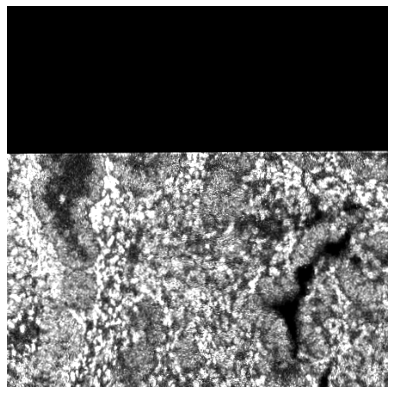

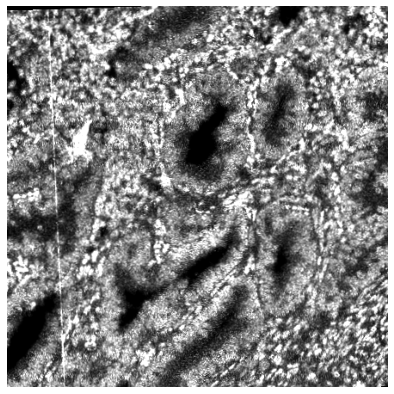

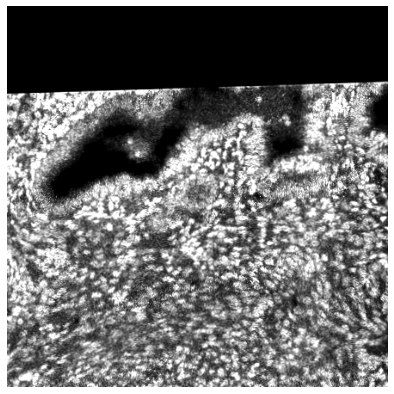

In [14]:
for i, img in enumerate(imgs_dapi):
    fig, ax = plt.subplots(figsize=(7, 7))
    ax.imshow(img, cmap="gray")
    ax.axis("off")
    plt.show()
    pil_img = Image.fromarray(img)
    pil_img.save(f'{experiment}_{i}.png')

# Import SIMS data

In [15]:
from skimage.transform import resize
from sklearn.neighbors import NearestNeighbors


def get_imgs_sims(experiment, name):
    with h5py.File(h5_data_dir / f"{experiment}.hdf5", "r") as f:
        imgs = f[name][:]
        labels = list(f[name].attrs["labels"])
    return imgs, labels


def get_imgs_index(imgs, index_list, fov_dim):

    imgs_subset = imgs[index_list, :, :]
    img_combined = np.sum(imgs_subset, axis=0)
    img_downscale = resize(img_combined, (fov_dim, fov_dim), anti_aliasing=False)
    return img_downscale

In [16]:
imgs_sims = []

for i, dataset in enumerate(datasets):
    try:
        info = my_utils.load_pkl(match_info_dir / f"{experiment}_{dataset}.pickle")
    except:
        continue
    imgs, labels = get_imgs_sims(experiment, dataset)
    # Read nulcie channel
    img_nuclei_downscale = get_imgs_index(imgs, [18, 32], fov_dim=imgs_dapi[i].shape[0])
    # Contrast streching
    p2, p98 = np.percentile(img_nuclei_downscale, (20, 99))
    img_nuclei_downscale = exposure.rescale_intensity(
        img_nuclei_downscale, in_range=(p2, p98), out_range=(0, 100)
    )
    img_nuclei_downscale = img_nuclei_downscale.astype(np.uint8)

    imgs_sims.append(img_nuclei_downscale)

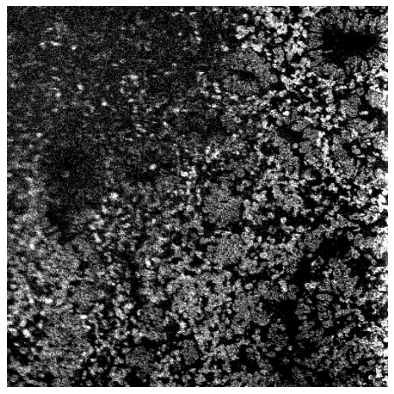

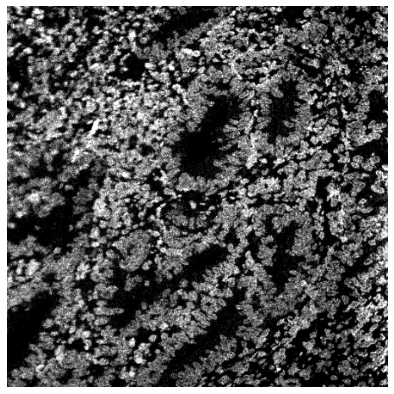

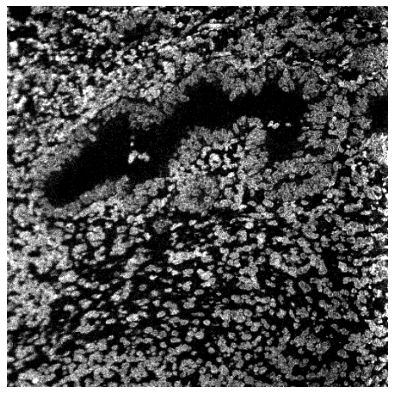

In [17]:
for img in imgs_sims:
    fig, ax = plt.subplots(figsize=(7, 7))
    ax.imshow(img, cmap="gray")
    ax.axis("off")
    plt.show()

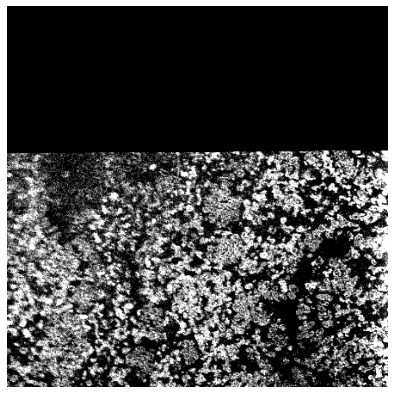

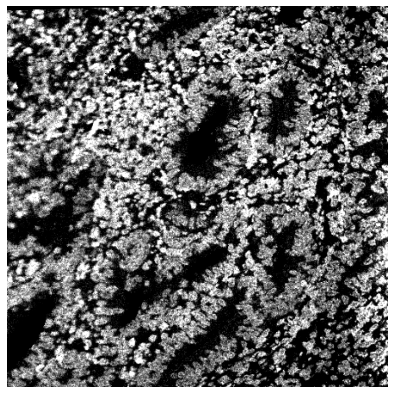

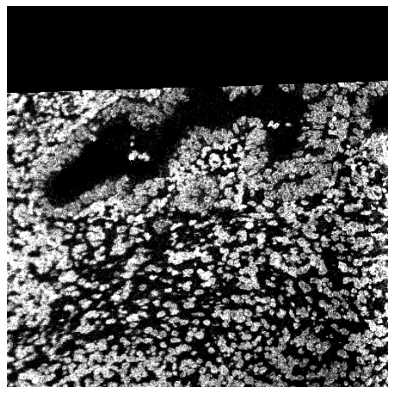

In [18]:
imgs_seg = []
for i, img in enumerate(imgs_sims):
    mask = imgs_dapi[i]>10
    img = np.where(mask, img, 0)
    img = contrast_stretching(img)
    fig, ax = plt.subplots(figsize=(7, 7))
    ax.imshow(img, cmap="gray")
    ax.axis("off")
    plt.show()
    # pil_img = Image.fromarray(img)
    # pil_img.save(f'{experiment}_{i}.png')
    imgs_seg.append(img)

In [19]:
# import napari
# i = 1

# viewer = napari.view_image(imgs_sims[i])
# viewer.add_image(imgs_dapi[i])

# Segmentation

In [20]:
import skimage.io
from scipy.ndimage import distance_transform_edt
from skimage.segmentation import mark_boundaries


def save_mask(mask, folder, region):
    path = os.path.join(folder, f"{region}" + ".tif")
    skimage.io.imsave(path, mask)


def expand_labels(label_image, distance=1):
    distances, nearest_label_coords = distance_transform_edt(
        label_image == 0, return_indices=True
    )
    labels_out = np.zeros_like(label_image)
    dilate_mask = distances <= distance
    # build the coordinates to find nearest labels,
    # in contrast to [1] this implementation supports label arrays
    # of any dimension
    masked_nearest_label_coords = [
        dimension_indices[dilate_mask] for dimension_indices in nearest_label_coords
    ]
    nearest_labels = label_image[tuple(masked_nearest_label_coords)]
    labels_out[dilate_mask] = nearest_labels
    return labels_out

In [21]:
# from cellpose import models, utils

# # DEFINE CELLPOSE MODEL
# # model_type='cyto' or model_type='nuclei'
# model = models.Cellpose(gpu=False, model_type="nuclei")


# # Cyto segmentation
# channels = [0, 0]
# masks, flows, styles, diams = model.eval(
#     imgs_seg,
#     diameter=5,
#     flow_threshold=20.0,
#     cellprob_threshold=-6.0,
#     channels=channels,
#     resample=True,
# )

In [22]:
cell_pro_path = Path.cwd() / 'mask image util'
mask0 = skimage.io.imread(cell_pro_path / f'mask_{core}_0.tiff')
mask1 = skimage.io.imread(cell_pro_path / f'mask_{core}_1.tiff')
mask2 = skimage.io.imread(cell_pro_path / f'mask_{core}_2.tiff')

masks = [mask0, mask1, mask2]

In [23]:
masks_expanded = []
for mask in masks:
    masks_expanded.append(expand_labels(mask, distance=2))

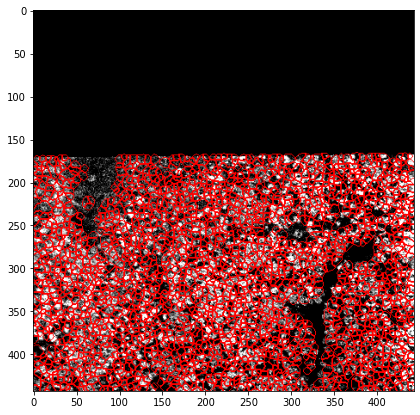

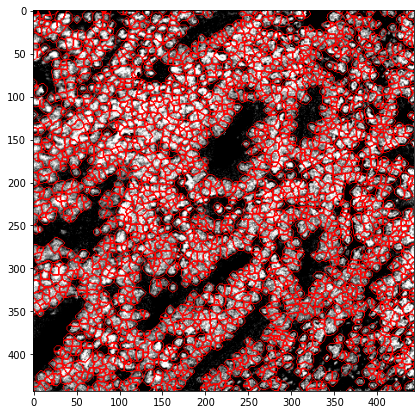

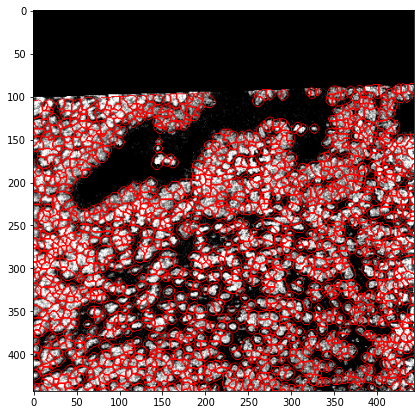

In [24]:
for i, mask in enumerate(masks_expanded):
    img_dapi = imgs_seg[i]

    img_bnd = mark_boundaries(img_dapi, mask, color=(1, 0, 0))

    fig, ax = plt.subplots(figsize=(7, 7))
    ax.imshow(img_bnd, cmap="gray")

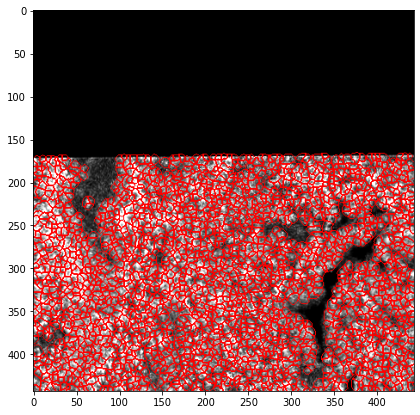

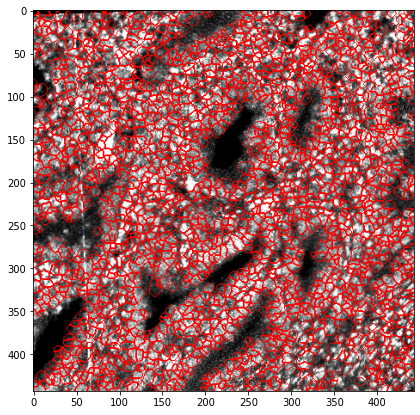

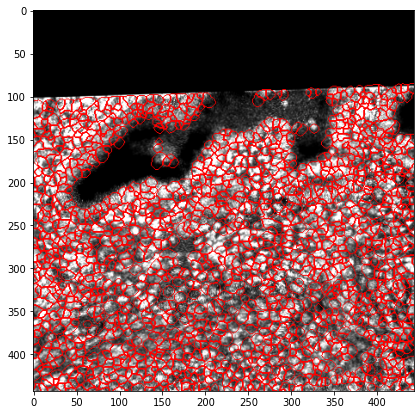

In [25]:
for i, mask in enumerate(masks_expanded):
    img_dapi = imgs_dapi[i]

    img_bnd = mark_boundaries(img_dapi, mask, color=(1, 0, 0))

    fig, ax = plt.subplots(figsize=(7, 7))
    ax.imshow(img_bnd, cmap="gray")

In [155]:
# for i, dataset in enumerate(datasets):
#     try:
#         info = my_utils.load_pkl(match_info_dir / f"{experiment}_{dataset}.pickle")
#     except:
#         continue
#     save_mask(masks_expanded[i], data_dir / "masks", f"{experiment}_{dataset}")

C:\Users\thu71\AppData\Local\Temp\ipykernel_20784\1840332102.py:8: UserWarning: Y:\coskun-lab\Thomas\ScSpaMet\data\masks\endometrium_L11_1.tif is a low contrast image
  skimage.io.imsave(path, mask)
C:\Users\thu71\AppData\Local\Temp\ipykernel_20784\1840332102.py:8: UserWarning: Y:\coskun-lab\Thomas\ScSpaMet\data\masks\endometrium_L11_2.tif is a low contrast image
  skimage.io.imsave(path, mask)
C:\Users\thu71\AppData\Local\Temp\ipykernel_20784\1840332102.py:8: UserWarning: Y:\coskun-lab\Thomas\ScSpaMet\data\masks\endometrium_L11_3.tif is a low contrast image
  skimage.io.imsave(path, mask)
